In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [2]:
# Connect to SQLite database
db_path = "C:\\Users\\deepi\\Downloads\\Concert ai\\SDS_techTest_Feb2025\\SDS_techTest_Oct2024\\techTest.db"
conn = sqlite3.connect(db_path)

# Load all tables into DataFrames
df_patient = pd.DataFrame(pd.read_sql("SELECT * FROM patient", conn))
df_diagnosis = pd.DataFrame(pd.read_sql("SELECT * FROM diagnosis", conn))
df_biomarker = pd.DataFrame(pd.read_sql("SELECT * FROM biomarker", conn))

# Close the database connection
conn.close()

print(df_patient.info())
print(df_diagnosis.info())
print(df_biomarker.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  1000 non-null   object
 1   dob         1000 non-null   object
 2   dod         1000 non-null   object
 3   gender      1000 non-null   object
dtypes: object(4)
memory usage: 31.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3026 entries, 0 to 3025
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   patient_id           3026 non-null   object
 1   diagnosis_date       3026 non-null   object
 2   diagnosis_code       3026 non-null   object
 3   diagnosis_code_type  3026 non-null   object
dtypes: object(4)
memory usage: 94.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3049 entries, 0 to 3048
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ---

In [3]:
# Convert dates to datetime format, handle errors, and extract only the date part  
df_patient["dob"] = pd.to_datetime(df_patient["dob"], errors="coerce").dt.date
df_patient["dod"] = pd.to_datetime(df_patient["dod"], errors="coerce").dt.date
df_diagnosis["diagnosis_date"] = pd.to_datetime(df_diagnosis["diagnosis_date"], errors="coerce").dt.date
df_biomarker["test_date"] = pd.to_datetime(df_biomarker["test_date"], errors="coerce").dt.date

# Display the first few rows to verify
print(df_patient.head())
print(df_diagnosis.head())
print(df_biomarker.head())


#Merge the dataframes on 'patient_id'
df_merged = df_patient.merge(df_diagnosis, on='patient_id', how='left') \
                    .merge(df_biomarker, on='patient_id', how='left')
print(df_merged.info())

                             patient_id         dob         dod     gender
0  019d3689-e49a-4f23-8ca1-65379907230b  1966-07-20  2042-06-15     female
1  81de4975-519f-48c6-a5fa-a57d891495a6  1930-08-24  1970-06-04     female
2  dbed4b3e-33ba-4856-a78d-3db6d211def8  1963-04-30  2036-01-19       NULL
3  32808df0-103c-409e-ad6b-60ec55d60612  1944-03-20  1981-11-05  nonbinary
4  774e6b8d-245a-46cc-8e7d-56f30c5b3d3d  1932-06-24  1977-04-11       male
                             patient_id diagnosis_date diagnosis_code  \
0  019d3689-e49a-4f23-8ca1-65379907230b     2020-06-13            C50   
1  019d3689-e49a-4f23-8ca1-65379907230b     1996-10-05          C50.4   
2  019d3689-e49a-4f23-8ca1-65379907230b     2004-10-30          C50.4   
3  81de4975-519f-48c6-a5fa-a57d891495a6     1986-04-01            C50   
4  dbed4b3e-33ba-4856-a78d-3db6d211def8     1997-12-21            C51   

  diagnosis_code_type  
0               icd10  
1               icd10  
2               icd10  
3              

Data maturity 

Calculate the summary statistics and plot the distribution of follow up time for BC patients.
Follow up time: The duration of time between the initial diagnosis date and last encounter in the database for a given patient.

STEPS : 
Filter Data – Select only breast cancer (BC) patients.
Calculate Initial Diagnosis Date – Earliest diagnosis_date per patient.
Calculate Last Encounter Date – Latest of diagnosis_date and test_date per patient.
Calculate Follow-Up Time – Difference in years between initial_diagnosis_date and last_encounter_date.

In [4]:
# Filter patients with diagnosis codes starting with "C50" (Breast Cancer)
bc_patients = df_merged[df_merged["diagnosis_code"].str.match(r"^C50.*")]

initial_diagnosis = bc_patients.groupby("patient_id")["diagnosis_date"].min().reset_index()
initial_diagnosis.rename(columns={"diagnosis_date": "initial_diagnosis_date"}, inplace=True)

# Last encounter from diagnosis table
last_diagnosis = bc_patients.groupby("patient_id")["diagnosis_date"].max().reset_index()

# Last encounter from biomarker table
last_biomarker = bc_patients.groupby("patient_id")["test_date"].max().reset_index()

# Merge both tables and take the maximum date
last_encounter = pd.merge(last_diagnosis, last_biomarker, on="patient_id", how="outer")

# Get the latest encounter date from either diagnosis or biomarker
last_encounter["last_encounter_date"] = last_encounter[["diagnosis_date", "test_date"]].max(axis=1)

# Keep only relevant columns
last_encounter = last_encounter[["patient_id", "last_encounter_date"]]

# Merge initial diagnosis and last encounter dates
follow_up_data = pd.merge(initial_diagnosis, last_encounter, on="patient_id", how="left")

# Compute follow-up time in years (No need for .dt)
follow_up_data["follow_up_time_years"] = ((follow_up_data["last_encounter_date"] - follow_up_data["initial_diagnosis_date"]).apply(lambda x: x.days) / 365).round(2)


Summary Statistics for Follow-Up Time (Years) - Including 0-Year Follow-Ups:
count    941.00
mean      27.07
std       16.50
min        0.00
25%       15.10
50%       27.31
75%       38.08
max       73.79
Name: follow_up_time_years, dtype: float64

Summary Statistics for Follow-Up Time (Years) - Excluding 0-Year Follow-Ups:
count    857.00
mean      29.72
std       14.84
min        0.05
25%       19.65
50%       29.04
75%       39.32
max       73.79
Name: follow_up_time_years, dtype: float64


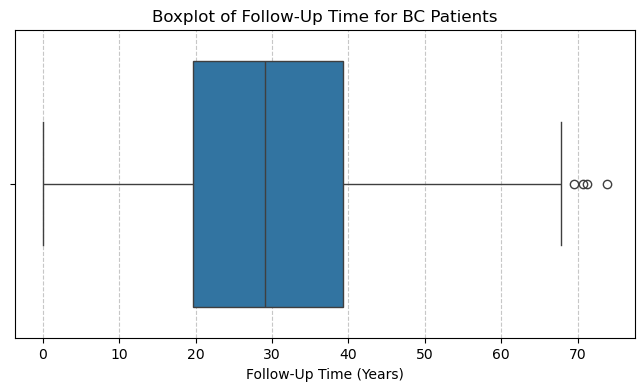

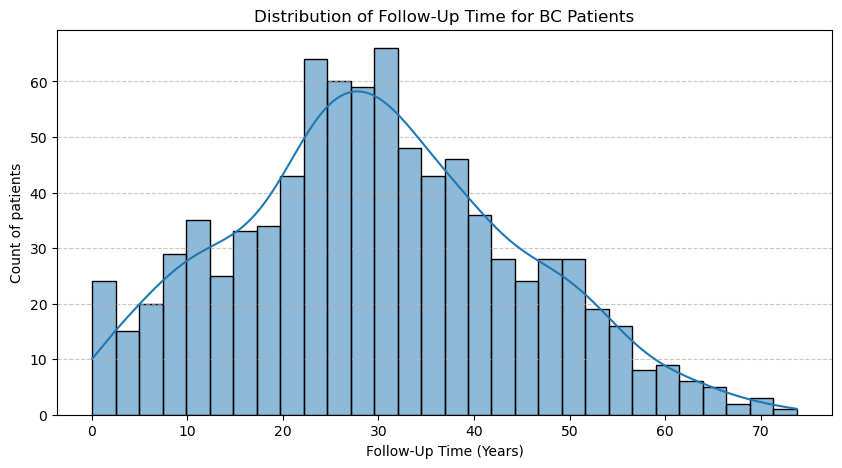

In [5]:
# Summary Statistics (Including 0-Year Follow-Ups)
print("Summary Statistics for Follow-Up Time (Years) - Including 0-Year Follow-Ups:")
print(follow_up_data["follow_up_time_years"].describe().round(2))

# Summary Statistics (Excluding 0-Year Follow-Ups)
follow_up_data_dropped = follow_up_data[follow_up_data["follow_up_time_years"] > 0]
print("\nSummary Statistics for Follow-Up Time (Years) - Excluding 0-Year Follow-Ups:")
print(follow_up_data_dropped["follow_up_time_years"].describe().round(2))


# Boxplot for follow-up time distribution
plt.figure(figsize=(8, 4))
sns.boxplot(x=follow_up_data_dropped["follow_up_time_years"])
plt.xlabel("Follow-Up Time (Years)")
plt.title("Boxplot of Follow-Up Time for BC Patients")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

# Histogram with KDE for distribution
plt.figure(figsize=(10, 5))
sns.histplot(follow_up_data_dropped["follow_up_time_years"], bins=30, kde=True)
plt.xlabel("Follow-Up Time (Years)")
plt.ylabel("Count of patients")
plt.title("Distribution of Follow-Up Time for BC Patients")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Data maturity 

-Calculate the summary statistics and plot the distribution of age at initial diagnosis for BC patients
Compute Age at Initial Diagnosis – Difference in years between initial_diagnosis_date and dob.


Summary Statistics for Age at Initial Diagnosis:
count    941.00
mean      37.24
std       15.36
min       19.21
25%       24.88
50%       32.89
75%       44.90
max       89.04
Name: age_at_diagnosis, dtype: float64


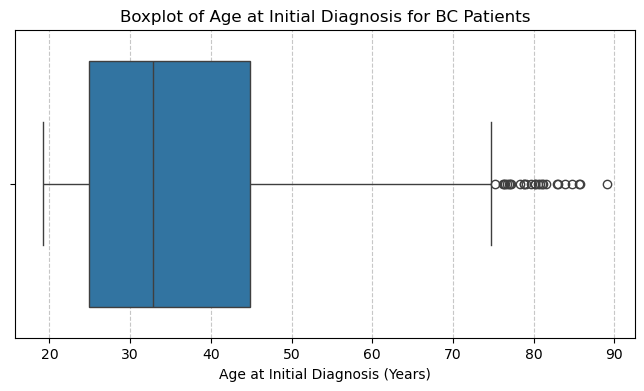

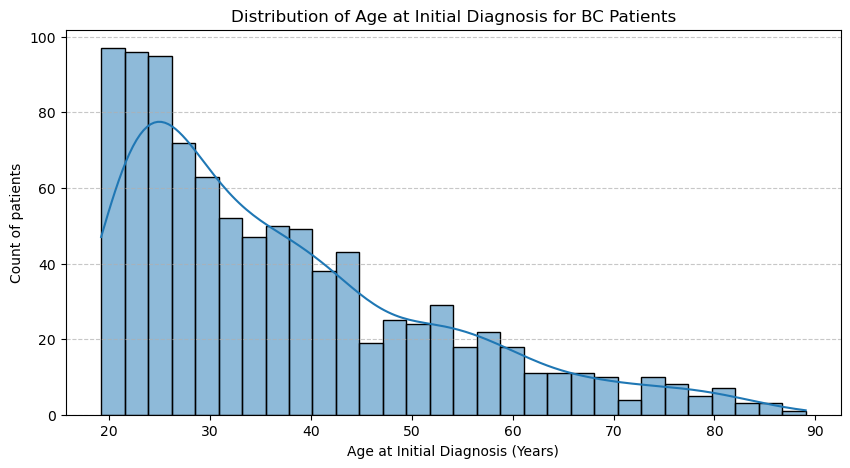

In [6]:
# Merge BC patients' initial diagnosis date with patient dob
bc_age_data = pd.merge(initial_diagnosis, df_patient[["patient_id", "dob"]], on="patient_id", how="left")

# Calculate age at initial diagnosis
bc_age_data["age_at_diagnosis"] = ((bc_age_data["initial_diagnosis_date"] - bc_age_data["dob"]).apply(lambda x: x.days) / 365).round(2)

# Summary statistics
summary_stats_age = bc_age_data["age_at_diagnosis"].describe().round(2)
print("Summary Statistics for Age at Initial Diagnosis:")
print(summary_stats_age)

# Boxplot for age distribution
plt.figure(figsize=(8, 4))
sns.boxplot(x=bc_age_data["age_at_diagnosis"])
plt.xlabel("Age at Initial Diagnosis (Years)")
plt.title("Boxplot of Age at Initial Diagnosis for BC Patients")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

# Histogram with KDE for age distribution
plt.figure(figsize=(10, 5))
sns.histplot(bc_age_data["age_at_diagnosis"], bins=30, kde=True)
plt.xlabel("Age at Initial Diagnosis (Years)")
plt.ylabel("Count of patients")
plt.title("Distribution of Age at Initial Diagnosis for BC Patients")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Steps to Compute HER2 Status Metrics Using bc_patients

    Filter HER2 Biomarker Tests → (biomarker_name = 'HER2').
    Compute Key Metrics:
        Intent to Test Rate = % of BC patients who had HER2 testing.
        Tested Rate = % of HER2-tested patients with a valid test result.
        Negativity Rate = % of HER2-tested patients with a negative result.

In [7]:
# Get unique patient IDs for breast cancer patients  
bc_patient_ids = bc_patients["patient_id"].unique() 

# Filter records where the biomarker tested is HER2  
her2_tests = bc_patients[bc_patients["biomarker_name"] == "HER2"]

# Count the number of unique patients who were tested for HER2  
patients_tested_for_her2 = her2_tests["patient_id"].nunique()

# Calculate the intent-to-test rate as the percentage of breast cancer patients tested for HER2  
intent_to_test_rate = (patients_tested_for_her2 / len(bc_patient_ids)) * 100
intent_to_test_rate

# Define valid test results (exclude NA, Unknown, Inconclusive)
valid_results = ["Positive", "Negative", "Equivocal"]
her2_valid_tests = her2_tests[her2_tests["test_result"].isin(valid_results)]

# Tested Rate: % of HER2-tested patients with a valid test result
tested_rate = (her2_valid_tests["patient_id"].nunique() / patients_tested_for_her2) * 100

# Negativity Rate: % of HER2-tested patients with a negative result
her2_negative_tests = her2_valid_tests[her2_valid_tests["test_result"] == "Negative"]
negativity_rate = (her2_negative_tests["patient_id"].nunique() / patients_tested_for_her2) * 100

# Print Results
print(f"Intent to Test Rate for HER2: {intent_to_test_rate:.2f}%")
print(f"Tested Rate for HER2: {tested_rate:.2f}%")
print(f"Negativity Rate for HER2: {negativity_rate:.2f}%")

Intent to Test Rate for HER2: 81.30%
Tested Rate for HER2: 84.71%
Negativity Rate for HER2: 42.88%


Survival time
    - Perform a statistical test to calculate the summary statistics for survival time stratifying patients by age at initial diagnosis of 60 years old .
    - Plot a Kaplan-Meier curve stratifying patients by age at initial diagnosis of 60 years old.
                                                                    
*Merge Data – Join bc_patients with initial_diagnosis, keeping only the earliest diagnosis per patient.
*Compute Age at Diagnosis – Calculate age at initial diagnosis using dob and initial_diagnosis_date.
*Calculate Survival Time – Compute survival time in years as the difference between dod (date of death) and initial_diagnosis_date.
*Remove patients negative survival times.
*Define Event Observed – 1 if DOD exists, 0 if still alive (using today's date for alive patients).
*Stratify by Age – Categorize patients into two groups: <60 and 60+.
*Perform Log-Rank Test – Compare survival distributions between the two age groups.
*Plot Kaplan-Meier Curve – Visualize survival probability over time for both age groups.

Summary Statistics for Survival Time by Age Group:
           count   mean    std   min    25%    50%    75%    max
age_group                                                       
60+         20.0   7.11   5.05  0.01   2.86   6.51  10.01  16.58
<60        716.0  26.51  15.22  0.45  14.40  25.70  37.21  62.50

Log-Rank Test P-Value: 1.6530529674598282e-23


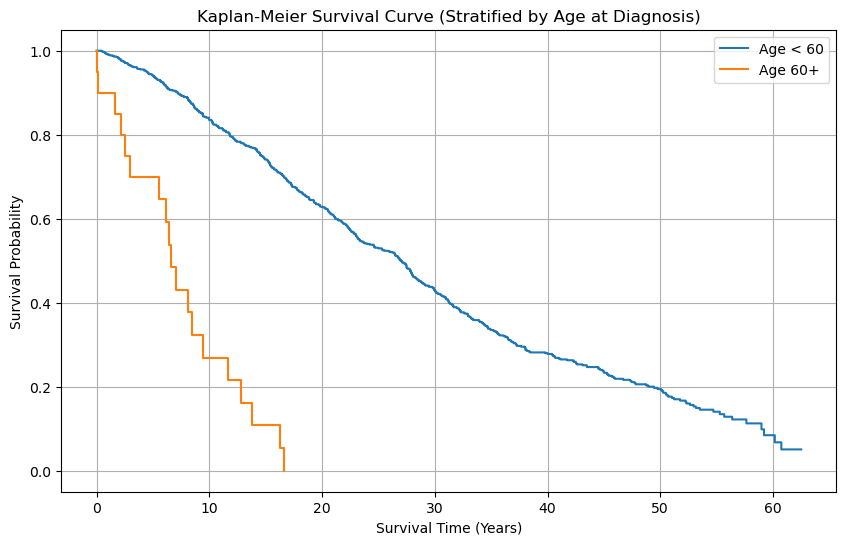

In [8]:
# Step 1: Merge with bc_patients, keeping only the earliest diagnosis per patient
bc_patients = bc_patients.merge(initial_diagnosis, on="patient_id", how="left")

# Keep only the earliest diagnosis per patient  
bc_patients = bc_patients.sort_values("initial_diagnosis_date").groupby("patient_id", as_index=False).first()

# Step 2: Compute age at initial diagnosis
bc_patients["age_at_diagnosis"] = ((bc_patients["initial_diagnosis_date"] - bc_patients["dob"]).apply(lambda x: x.days) / 365).round(2)

# Step 3: Define today's date for censoring
today = datetime.date.today()  

# Step 4: Compute survival time (in years), handling censoring
bc_patients["survival_time"] = ((bc_patients["dod"] - bc_patients["initial_diagnosis_date"]).apply(lambda x: x.days) / 365).round(2)
bc_patients = bc_patients[bc_patients["survival_time"] > 0]  # Keep only positive survival times

# Step 5: Identify whether the event (death) was observed
bc_patients["event_observed"] = bc_patients["dod"] <= today

# Step 6: Stratify into age groups (<60 and 60+)
bc_patients["age_group"] = np.where(bc_patients["age_at_diagnosis"] < 60, "<60", "60+")

# Step 7: Perform Log-Rank Test (Survival Difference)
group1 = bc_patients[bc_patients["age_group"] == "<60"]
group2 = bc_patients[bc_patients["age_group"] == "60+"]

logrank_result = logrank_test(
    group1["survival_time"],  
    group2["survival_time"],  
    event_observed_A=group1["event_observed"],  
    event_observed_B=group2["event_observed"]  
)

# Print Summary Statistics & Log-Rank Test Results
summary_stats = bc_patients.groupby("age_group")["survival_time"].describe().round(2)
print("Summary Statistics for Survival Time by Age Group:")
print(summary_stats)
print("\nLog-Rank Test P-Value:", logrank_result.p_value)

# Step 8: Plot Kaplan-Meier Survival Curve
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Fit & Plot for Age < 60
kmf1.fit(group1["survival_time"], event_observed=group1["event_observed"], label="Age < 60")
kmf1.plot_survival_function(ci_show=False)

# Fit & Plot for Age 60+
kmf2.fit(group2["survival_time"], event_observed=group2["event_observed"], label="Age 60+")
kmf2.plot_survival_function(ci_show=False)

plt.xlabel("Survival Time (Years)")
plt.ylabel("Survival Probability")
plt.title("Kaplan-Meier Survival Curve (Stratified by Age at Diagnosis)")
plt.legend()
plt.grid()
plt.show()